# Finetuning

A LLM goes through various stages of finetuning.

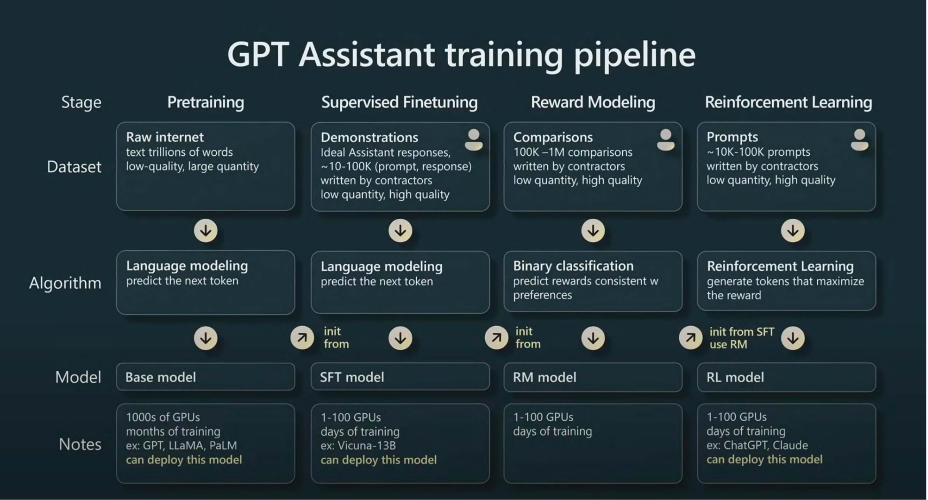

- Pretrained models or base models are great for raw token completions. E.g., [gemma-2-2b]
- SFT (Supervised Finetuning) improves the base models with "instruction" capability. At this stage the model becomes usable. E.g., [gemma-2-2b-it]
- RM/RL finetuning aligns the model with preferred answers based on reward models.

Please refer to [State of GPT](https://github.com/giachat/State-of-GPT-2023/blob/main/State%20of%20GPT%20-%20Microsoft%20Build%202023%20RD.pdf) by Andrej Karpathy (Microsoft Build 2023) for a nice primer into details of each stage.

[gemma-2-2b]: https://huggingface.co/google/gemma-2-2b
[gemma-2-2b-it]: https://huggingface.co/google/gemma-2-2b-it

# Setup libraries

This notebook uses [unsloth] for optimized finetuning with low memory usage. You can also use huggingface's [TRL] directly.

[unsloth]: https://github.com/unslothai/unsloth
[TRL]: https://huggingface.co/docs/trl/sft_trainer

In [1]:
%%capture
!mamba install --force-reinstall aiohttp -y
!pip install -U "xformers<0.0.26" --index-url https://download.pytorch.org/whl/cu121
!pip install "unsloth[kaggle-new] @ git+https://github.com/unslothai/unsloth.git"

# Temporary fix for https://github.com/huggingface/datasets/issues/6753
!pip install datasets==2.16.0 fsspec==2023.10.0 gcsfs==2023.10.0

import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
!python -m xformers.info
from xformers import __version__ as xformers_version
xformers_version

xFormers 0.0.25.post1
memory_efficient_attention.ckF:                    unavailable
memory_efficient_attention.ckB:                    unavailable
memory_efficient_attention.ck_decoderF:            unavailable
memory_efficient_attention.ck_splitKF:             unavailable
memory_efficient_attention.cutlassF:               available
memory_efficient_attention.cutlassB:               available
memory_efficient_attention.decoderF:               available
memory_efficient_attention.flshattF@v2.5.6:        available
memory_efficient_attention.flshattB@v2.5.6:        available
memory_efficient_attention.smallkF:                available
memory_efficient_attention.smallkB:                available
memory_efficient_attention.triton_splitKF:         unavailable
indexing.scaled_index_addF:                        unavailable
indexing.scaled_index_addB:                        unavailable
indexing.index_select:                             unavailable
sequence_parallel_fused.write_values:          

'0.0.25.post1'

# Download base model

We use a 4bit quantized model as base for quicker download.

In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models to reduce memory usage
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gemma-2-2b-it-bnb-4bit", # Reminder we support ANY Hugging Face model!
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2024-08-21 18:54:50.047095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 18:54:50.047202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 18:54:50.213206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


==((====))==  Unsloth 2024.8: Fast Gemma2 patching. Transformers = 4.44.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.25.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.22G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

# Scenario: Function calling

We'll use a scenario common amongst the Agentic systems. Given a natural language query and a set of tools available, choose the most appropriate tool to answer the query.


## Get the dataset

In [4]:
from datasets import load_dataset

# load dataset with function calls
ds = load_dataset("hypervariance/function-calling-sharegpt")
display(ds)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['conversations'],
        num_rows: 86864
    })
})

In [5]:
# Check the model's conversation format
tokenizer.chat_template

"{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + message['content'] | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"

In [6]:
# We need to convert the dataset conversations into Model's conversation format

# We can't use multi line strings for the chat template because newlines and tabs get interpreted. We have to do this wacky string instead.
# https://huggingface.co/docs/transformers/main/en/chat_templating#notes-on-whitespace
# BOS and EOS automatically added https://huggingface.co/docs/transformers/en/model_doc/gemma#transformers.GemmaTokenizer.bos_token
# Uses same prompt format as gemma-2b/7b-it
# System prompt part of user prompt, due to the model not having a system prompt
chat_template = \
"{% for message in messages %}" \
    "{% if message['from'] == 'system' %}" \
        "{{ '<start_of_turn>user\\n' + message['value'] }}" \
    "{% elif message['from'] == 'human' %}" \
        "{% if loop.index0 == 1 %}" \
            "{{ '\\nUser Question:\\n' }}" \
        "{% else %}" \
            "{{ '<start_of_turn>user\\n' }}" \
        "{% endif %}" \
        "{{ message['value'] + '<end_of_turn>' }}" \
    "{% elif message['from'] == 'gpt' %}" \
        "{{ '<start_of_turn>model\\n'  + message['value'] + ' ' + '<end_of_turn>' }}" \
    "{% elif message['from'] == 'function_response' %}" \
        "{{ '<start_of_turn>user\\n'  + message['value'] + ' ' + '<end_of_turn>' }}" \
    "{% endif %}" \
    "{% if not loop.last %}" \
        "{{ '\\n' }}" \
    "{% endif %}" \
"{% endfor %}" \
"{% if not add_generation_prompt is defined %}" \
    "{% set add_generation_prompt = false %}" \
"{% endif %}" \
"{% if add_generation_prompt %}" \
    "{{ '\\n<start_of_turn>model\\n' }}" \
"{% endif %}"
print(chat_template)

tokenizer.chat_template = chat_template

{% for message in messages %}{% if message['from'] == 'system' %}{{ '<start_of_turn>user\n' + message['value'] }}{% elif message['from'] == 'human' %}{% if loop.index0 == 1 %}{{ '\nUser Question:\n' }}{% else %}{{ '<start_of_turn>user\n' }}{% endif %}{{ message['value'] + '<end_of_turn>' }}{% elif message['from'] == 'gpt' %}{{ '<start_of_turn>model\n'  + message['value'] + ' ' + '<end_of_turn>' }}{% elif message['from'] == 'function_response' %}{{ '<start_of_turn>user\n'  + message['value'] + ' ' + '<end_of_turn>' }}{% endif %}{% if not loop.last %}{{ '\n' }}{% endif %}{% endfor %}{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% if add_generation_prompt %}{{ '\n<start_of_turn>model\n' }}{% endif %}


In [7]:
ds = load_dataset("hypervariance/function-calling-sharegpt", split="train").train_test_split(train_size=0.8, shuffle=False)
dataset_train = ds["train"].map(
    lambda x: {
        "formatted_chat": tokenizer.apply_chat_template(
            x["conversations"], tokenize=False,
        )
    }
)
dataset_test = ds["test"].map(
    lambda x: {
        "formatted_chat": tokenizer.apply_chat_template(
            x["conversations"], tokenize=False,
        )
    }
)

Map:   0%|          | 0/69491 [00:00<?, ? examples/s]

Map:   0%|          | 0/17373 [00:00<?, ? examples/s]

In [8]:
# This should match the above!
print(dataset_train[122]["formatted_chat"])

<start_of_turn>user
You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "calculate_tip",
    "description": "Calculate the tip amount based on the bill total and tip percentage",
    "parameters": {
        "type": "object",
        "properties": {
            "bill_total": {
                "type": "number",
                "description": "The total amount of the bill"
            },
            "tip_percentage": {
                "type": "number",
                "description": "The percentage of the tip"
            }
        },
        "required": [
            "bill_total",
            "tip_percentage"
        ]
    }
}

To use these functions respond with:
<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>

Edge cases you must handle:
 - If there are no functions that match the user request, you will respond politely that you cannot help.

User Question:
Can you 

## Default behavior of the model

Let's try to see if in its current state the model is able to respond accurately.

In [9]:
# Let's create a sample prompt from above, we will only take the system and first user prompt
test_prompt="""<start_of_turn>user
You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "calculate_mortgage_payment",
    "description": "Calculate the monthly mortgage payment",
    "parameters": {
        "type": "object",
        "properties": {
            "loan_amount": {
                "type": "number",
                "description": "The loan amount"
            },
            "interest_rate": {
                "type": "number",
                "description": "The annual interest rate"
            },
            "loan_term": {
                "type": "integer",
                "description": "The loan term in years"
            }
        },
        "required": [
            "loan_amount",
            "interest_rate",
            "loan_term"
        ]
    }
}

To use these functions respond with:
<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>

Edge cases you must handle:
 - If there are no functions that match the user request, you will respond politely that you cannot help.

User Question:
Can you please book a flight for me from New York to London?<end_of_turn>
<start_of_turn>model"""

# Run an inference
FastLanguageModel.for_inference(model)
inputs = tokenizer([test_prompt], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

<bos><start_of_turn>user
You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "calculate_mortgage_payment",
    "description": "Calculate the monthly mortgage payment",
    "parameters": {
        "type": "object",
        "properties": {
            "loan_amount": {
                "type": "number",
                "description": "The loan amount"
            },
            "interest_rate": {
                "type": "number",
                "description": "The annual interest rate"
            },
            "loan_term": {
                "type": "integer",
                "description": "The loan term in years"
            }
        },
        "required": [
            "loan_amount",
            "interest_rate",
            "loan_term"
        ]
    }
}

To use these functions respond with:
<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>

Edge cases you must handl

# Training

In [10]:
# Let's pick a smaller subset for training
smaller_train = dataset_train.select(range(4000))

In [11]:
dict(model.named_modules())['']

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): GemmaFixedRotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSN

## LoRA parameters

TODO: note on layers, rank etc.

In [12]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.8 patched 26 layers with 26 QKV layers, 26 O layers and 26 MLP layers.


In [13]:
dict(model.named_modules())['']

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bit(
  

In [14]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
    
print_trainable_parameters(model)

trainable params: 20766720 || all params: 2212794624 || trainable%: 0.9384838418696375


## Training parameters
Talk about the params here: lr, weight decay, 

In [15]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = smaller_train,
    dataset_text_field = "formatted_chat",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        
        # Use num_train_epochs = 1, warmup_ratio for full training runs!
        #warmup_steps = 5,
        #max_steps = 60,
        num_train_epochs = 2,

        learning_rate = 5e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 9873,
        output_dir = "outputs",
    ),
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map (num_proc=2):   0%|          | 0/4000 [00:00<?, ? examples/s]

In [16]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
3.266 GB of memory reserved.


## Train the model

- 400 samples, max_steps = 60, ~5mins
- 4000 samples, num_epochs = 2, num_steps = 1000, ~1.5hrs
- 1000 samples, num_epochs = 1, num_steps = 125, 12.19mins

In [17]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,000 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 1,000
 "-____-"     Number of trainable parameters = 20,766,720


Step,Training Loss
1,2.060800
2,2.096100
3,2.103000
4,1.622200
5,1.519800
6,1.466800
7,1.580800
8,1.379700
9,1.468700
10,1.252300


In [18]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

5688.5067 seconds used for training.
94.81 minutes used for training.
Peak reserved memory = 8.551 GB.
Peak reserved memory for training = 5.285 GB.
Peak reserved memory % of max memory = 58.008 %.
Peak reserved memory for training % of max memory = 35.852 %.


# Evaluation

In [19]:
FastLanguageModel.for_inference(model)

prompt = "<start_of_turn>user tell me a joke<end_of_turn><start_of_turn>model "
inputs = tokenizer(
[
    prompt
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

<bos><start_of_turn>user tell me a joke<end_of_turn><start_of_turn>model 
Why don't scientists trust atoms? 
Because they make up everything! <end_of_turn>


In [20]:
prompt = "What is the meaning of life?"
inputs = tokenizer(
[
    prompt
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

<bos>What is the meaning of life?

This question has been pondered by philosophers, theologians, and everyday people for centuries. There is no one answer that will satisfy everyone, as the meaning of life is a deeply personal and subjective question. However, some common themes and perspectives on the meaning of life include:

**1. Finding Purpose and Meaning:** Many


In [21]:
prompt = """<start_of_turn>user\nYou are a helpful assistant with access to the following functions. Use them if required -\n{\n    "name": "get_news_headlines",\n    "description": "Get the latest news headlines",\n    "parameters": {\n        "type": "object",\n        "properties": {\n            "country": {\n                "type": "string",\n                "description": "The country for which to fetch news"\n            }\n        },\n        "required": [\n            "country"\n        ]\n    }\n}\n\nTo use these functions respond with:\n<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>\n\nEdge cases you must handle:\n - If there are no functions that match the user request, you will respond politely that you cannot help.\n\nUser Question:\nCan you tell me the latest news headlines for the United States?<end_of_turn>"""

inputs = tokenizer(
[
    prompt
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

<bos><start_of_turn>user
You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "get_news_headlines",
    "description": "Get the latest news headlines",
    "parameters": {
        "type": "object",
        "properties": {
            "country": {
                "type": "string",
                "description": "The country for which to fetch news"
            }
        },
        "required": [
            "country"
        ]
    }
}

To use these functions respond with:
<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>

Edge cases you must handle:
 - If there are no functions that match the user request, you will respond politely that you cannot help.

User Question:
Can you tell me the latest news headlines for the United States?<end_of_turn>
<start_of_turn>model
<functioncall> {"name": "get_news_headlines", "arguments": '{"country": "United States"}'} </functioncall>

In [22]:
# Let's create a sample prompt from above, we will only take the system and first user prompt
test_prompt="""<start_of_turn>user
You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "calculate_mortgage_payment",
    "description": "Calculate the monthly mortgage payment",
    "parameters": {
        "type": "object",
        "properties": {
            "loan_amount": {
                "type": "number",
                "description": "The loan amount"
            },
            "interest_rate": {
                "type": "number",
                "description": "The annual interest rate"
            },
            "loan_term": {
                "type": "integer",
                "description": "The loan term in years"
            }
        },
        "required": [
            "loan_amount",
            "interest_rate",
            "loan_term"
        ]
    }
}

To use these functions respond with:
<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>

Edge cases you must handle:
 - If there are no functions that match the user request, you will respond politely that you cannot help.

User Question:
Can you please book a flight for me from New York to London?<end_of_turn>
<start_of_turn>model"""

# Run an inference
inputs = tokenizer([test_prompt], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
print(tokenizer.batch_decode(outputs)[0])

<bos><start_of_turn>user
You are a helpful assistant with access to the following functions. Use them if required -
{
    "name": "calculate_mortgage_payment",
    "description": "Calculate the monthly mortgage payment",
    "parameters": {
        "type": "object",
        "properties": {
            "loan_amount": {
                "type": "number",
                "description": "The loan amount"
            },
            "interest_rate": {
                "type": "number",
                "description": "The annual interest rate"
            },
            "loan_term": {
                "type": "integer",
                "description": "The loan term in years"
            }
        },
        "required": [
            "loan_amount",
            "interest_rate",
            "loan_term"
        ]
    }
}

To use these functions respond with:
<functioncall> {"name": "function_name", "arguments": {"arg_1": "value_1", "arg_1": "value_1", ...}} </functioncall>

Edge cases you must handl

# Save the model

In [23]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("hf_token")
!huggingface-cli login --token hf_token

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Traceback (most recent call last):
  File "/opt/conda/bin/huggingface-cli", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/commands/huggingface_cli.py", line 51, in main
    service.run()
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/commands/user.py", line 98, in run
    login(token=self.args.token, add_to_git_credential=self.args.add_to_git_credential)
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/_login.py", line 111, in login
    _login(token, add_to_git_credential=add_to_git_credential, write_permission=write_permission)
  File "/opt/conda/lib/python3.10/site-packages/huggingface_hub/_login.py", line 307, in _login
    raise ValueError("Invalid token passed!")
Value

In [24]:
# LoRA adapter only
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.model',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

In [25]:
# Save merged model
# Merge to 16bit
if True: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if True: model.push_to_hub_merged("codito/gemma-2-2b-it-func-test2", tokenizer, save_method = "merged_16bit", token = hf_token)

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

Unsloth: You have 2 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 2.2G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 18.8 out of 31.36 RAM for saving.


100%|██████████| 26/26 [00:00<00:00, 40.23it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving model/pytorch_model-00001-of-00002.bin...
Unsloth: Saving model/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: You are pushing to hub, but you passed your HF username = codito.
We shall truncate codito/gemma-2-2b-it-func-test2 to gemma-2-2b-it-func-test2


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 18.8 out of 31.36 RAM for saving.


100%|██████████| 26/26 [00:00<00:00, 37.80it/s]


Unsloth: Saving tokenizer...

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

 Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving gemma-2-2b-it-func-test2/pytorch_model-00001-of-00002.bin...
Unsloth: Saving gemma-2-2b-it-func-test2/pytorch_model-00002-of-00002.bin...


README.md:   0%|          | 0.00/581 [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Done.
Saved merged model to https://huggingface.co/codito/gemma-2-2b-it-func-test2
